# Préambule

Dès 1958, Charles David Keeling a débuté la mesure précise du taux de CO2 dans l'atmosphère à l'observatoire de Mauna Loa, Hawaii, États-Unis.  
Ces mesures, qui continuent aujourd'hui, ont permis de montrer une évolution périodique de CO2 dans l'hémisphère Nord. Celle-ci provenant du cycle de vie des plantes.  
De même, ces données ont montré une évolution continue du taux de CO2 dans l'atmosphère depuis 1958.

# Travail à faire

Le but de l'exercice est de réaliser un document computationnel pour :
* Réaliser un graphique qui montrera une oscillation périodique superposée à une évolution systématique plus lente.
* Séparer ces deux phénomènes. Caractériser l'oscillation périodique et proposer un modèle simple de la contribution lente
* Estimer ses paramètres et tenter une extrapolation jusqu'à 2025 (dans le but de pouvoir valider le modèle par des observations futures).
* Déposer dans FUN le résultat.

## Etat du système réalisant les calculs

In [1]:
# Installation de la librairie lmfit
!pip install lmfit

  Using cached https://files.pythonhosted.org/packages/24/40/11b12af7f322c1e20446c037c47344d89bab4922b8859419d82cf56d796d/scipy-1.2.3-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/3a/5f/47e578b3ae79e2624e205445ab77a1848acdaa2929a00eeef6b16eaaeb20/numpy-1.16.6-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/65/eb/1f97cb97bfc2390a276969c6fae16075da282f5058082d4cb10c6c5c1dba/six-1.14.0-py2.py3-none-any.whl


In [2]:
# Import des librairies
import time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from lmfit.models import QuadraticModel, Model
import lmfit
from sklearn.metrics import r2_score

In [3]:
# Affichage de la version des logiciels
import sys
import platform

print(f"Version de linux : {platform.uname()[3]:>57}")
print(f"Version du noyau linux : {platform.uname()[2]:>16}")
print(f"Architecture : {platform.uname()[5]:>16}\n")

print(f"Version de python : {sys.version:>56}")
print(f"Version de pandas : {pd.__version__:>10}")
print(f"Version de numpy : {np.__version__:>12}")
print(f"Version de lmfit : {lmfit.__version__:>11}")
print(f"Version de matplotlib : {matplotlib.__version__:>6}")

Version de linux :       #44~18.04.2-Ubuntu SMP Thu Apr 23 14:27:18 UTC 2020
Version du noyau linux : 5.3.0-51-generic
Architecture :           x86_64

Version de python :      3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Version de pandas :      1.0.3
Version de numpy :       1.18.2
Version de lmfit :       1.0.0
Version de matplotlib :  3.2.1


# Base de données

Les données sont disponibles sur le site Web de l'institut Scripps à l'adresse suivante:  
https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html

Pour notre étude, nous prendrons les relevés hebdomadaires : *weekly_in_situ_co2_mlo.csv* que l'on peut télécharger à l'adresse suiavnte : https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html

Nous travaillerons sur une base locale (copiée sur le serveur *jupyter* de l'INRIA) téléchargée le 13 avril 2020.
La totalité des documents nécessaires à cette étude seront committés sur le serveur *GitLab* de l'INRIA.

Les parties du code nécessaires à l'affichage des courbes ne sera pas affichées dans le rapport final. Elles seront tout de même accessibles dans le fichier *jupyter*.

In [4]:
# URL du fichier de données
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv"

In [5]:
# Vérification de la présence du fichier en local
# Si non, téléchargement à partir de l'URL
import os.path
import time
# Vérifier si le fichier existe ou non
if os.path.isfile('weekly_in_situ_co2_mlo.csv'):
    print("Fichier trouvé en local.")
    print(f"Dernière modification sur ce fichier : {time.ctime(os.path.getctime('weekly_in_situ_co2_mlo.csv'))}")
else:
    print("Fichier non trouvé en local.")
    print("Téléchargement du fichier sur le site Web.")
    # Copy du fichier à la racine
    os.system("wget " + data_url)
    print(f"Dernière modification sur ce fichier : {time.ctime(os.path.getctime('weekly_in_situ_co2_mlo.csv'))}")

Fichier trouvé en local.
Dernière modification sur ce fichier : Tue Apr 28 11:47:15 2020


# Vérification de la base de données

## Exploration des données

Nous commençons par analyser le contenu du fichier de données (fichier structuré *CSV*) pour ensuite faire un premier tracé de l'ensemble de la base de données.  
Nous utiliserons les libraries *pandas* et *matplotlib* pour *python 3.6*.

In [6]:
# Chargement de la base de données (CSV)
# Les lignes de commentaires sont ignorées
# Le séparateur de champs utilisé dans la base de données est la virgule (,)
# La colonne des dates est parsé et mise en index
date_parser = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]

data = pd.read_csv('weekly_in_situ_co2_mlo.csv', sep=',', comment='"', header=None,
                   names=["date", "CO2"])
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Les dates sont passées à l'index du dataframe
data.set_index('date', inplace=True)
data.shape

(3156, 1)

Les 44 premières lignes de commentaires du fichier brut n'ont pas été prises en compte (commande `comment='"'`).  
La base de données est composée de 3156 mesures et de 2 colonnes :
* date : date de relevé. Avec un relevé par semaine.
* CO2 : concentration de CO2 en *ppm*.

In [7]:
# Affichage partiel de la base de données mise en forme
data.head(5)

CO2
date              
1958-03-29  316.19
1958-04-05  317.31
1958-04-12  317.69
1958-04-19  317.58
1958-04-26  316.48

L'inspection visuelle de la base de données complète montre que le fichier est bien formé et ne semble pas comporter de valeurs manquantes ou aberrantes.  

## Vérification des données

Avant d'aller plus loin dans l'analyse, vérifions avec un code de validation (une fonction *builtin* de *pandas*) la robustesse de la base de données. Nous vérifions la présence de valeurs manquantes et le type des différentes variables (date, float).  
Par la suite, l'affichage sous forme graphique nous permettra d'avoir une vue globale de la base de données.

In [8]:
# La méthode .info() permet d'avoir une vision concise de la base de données
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3156 entries, 1958-03-29 to 2020-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     3156 non-null   float64
dtypes: float64(1)
memory usage: 49.3 KB


La base de données comporte 3156 lignes de valeurs numériques (float64) sans valeur manquante.  L'index est bien au format `datetime` allant du 29/03/1958 au 01/02/2020.

Nous allons tout de même vérifier la continuité des mesures. Le but étant de constater si nous avons bien une mesure par semaine.

In [9]:
# Création de la liste regroupant toutes les périodes
periods = [pd.Period(index, 'W') for index, _ in data.iterrows()]

# Extraction des périodes non contigues
empty_periods = []

for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        # On ajouté 1ns à la date de fin d'une période sans mesures pour avoir un compte rond
        # Les périoees sans mesures sont ajoutées dans une liste sous forme de tuple
        empty_periods.append((p1.end_time+pd.Timedelta(1), p2.start_time))
        print(f"Entre les semaines {p1.year}-{p1.week:<2} et {p2.year}-{p2.week:<2} \
                il y a {delta.days:<3} jours sans mesures.")

Entre les semaines 1958-18 et 1958-20                 il y a 7   jours sans mesures.
Entre les semaines 1958-21 et 1958-27                 il y a 35  jours sans mesures.
Entre les semaines 1958-33 et 1958-35                 il y a 7   jours sans mesures.
Entre les semaines 1958-36 et 1958-45                 il y a 56  jours sans mesures.
Entre les semaines 1959-5  et 1959-7                  il y a 7   jours sans mesures.
Entre les semaines 1959-10 et 1959-12                 il y a 7   jours sans mesures.
Entre les semaines 1959-21 et 1959-23                 il y a 7   jours sans mesures.
Entre les semaines 1959-32 et 1959-34                 il y a 7   jours sans mesures.
Entre les semaines 1962-33 et 1962-37                 il y a 21  jours sans mesures.
Entre les semaines 1962-51 et 1963-1                  il y a 7   jours sans mesures.
Entre les semaines 1963-6  et 1963-8                  il y a 7   jours sans mesures.
Entre les semaines 1963-17 et 1963-19                 il y a 7   

Nous avons donc plusieurs période sans mesures. Certaines de ces périodes sont longues.  
Dans le graphique qui suit, les données sont tracées avec interpolation linéaire des données manquantes. Ne constatant pas d'impact sur la forme de la courbe, nous pouvons considérer que la base est suffisante et ne nécessite pas d'imputer les données manquantes.

# Analyse des données

## Mise en évidence des composantes de l'évolution de la concentration de CO2 dans l'atmosphère

Un tracé sous forme graphique nous permettra de constater les phénomènes.  
Après l'affichage de la base complète, nous tracerons 2 sous-graphiques correspondant à l'évolution du taux de CO2 sur 2 années différentes. Une en début de base (du 01/01/1960 au 01/01/1961) et une autre en fin (du 01/01/2015 au 01/01/2016).  
Les périodes sans mesures apparaitront en rouge.

In [10]:
# Définition des périodes à afficher
mask1_1y = (data.index > '1960-01-01') & (data.index <= '1961-01-01')
mask2_1y = (data.index > '2015-01-01') & (data.index <= '2016-01-01')

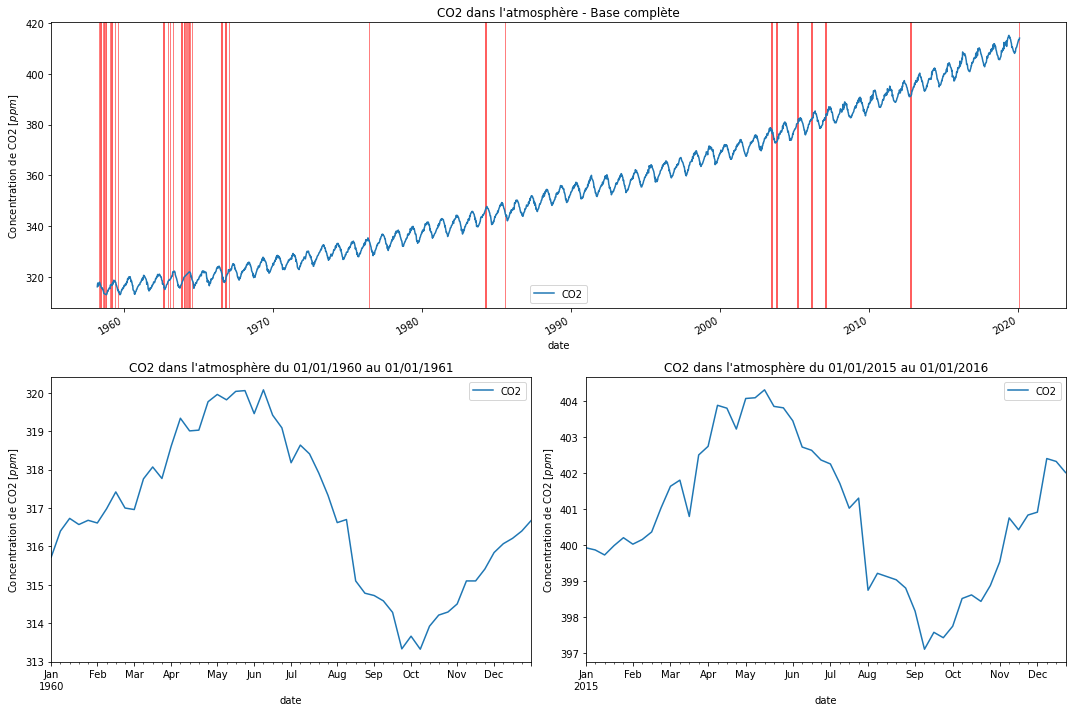

In [11]:
# Initialisation des graphs
# Graphs de 2 périodes différentes de 1 an
fig = plt.figure()
 
# Définition des axes
ax1 = plt.subplot(223)
ax2 = plt.subplot(224)
ax3 = plt.subplot(211)

# Titres des graphs
ax1.set_title("CO2 dans l'atmosphère du 01/01/1960 au 01/01/1961")
ax2.set_title("CO2 dans l'atmosphère du 01/01/2015 au 01/01/2016")
ax3.set_title("CO2 dans l'atmosphère - Base complète")

# Labels des axes
ax1.set_ylabel("Concentration de CO2 [$ppm$]")
ax2.set_ylabel("Concentration de CO2 [$ppm$]")
ax3.set_ylabel("Concentration de CO2 [$ppm$]")

# Graph sur la base complète
data[mask1_1y].plot(ax=ax1, figsize=(15,10))
data[mask2_1y].plot(ax=ax2, figsize=(15,10))
data.plot(ax=ax3, figsize=(15,10))
# Délimitation des zones sans mesures
for d1, d2 in empty_periods:
    ax3.axvspan(d1, d2, alpha=0.5, color='red')
    ax1.axvspan(d1, d2, alpha=0.5, color='red')
    ax2.axvspan(d1, d2, alpha=0.5, color='red')

# Optimisation de l'espacement entre les graphs
fig.tight_layout()

Nous constatons que l'évolution continue du CO2 dans l'atmosphère ne suit pas une courbe linaire. Le tendance est plutôt quadratique.  
Sur année, l'évolution est périodique est semble grossièrement coller à une sinusoïde.

## Caractérisation de la tendance continue

Pour cela, nous allons ajuster une courbe quadratique à la base complète en utilisant la librairie *lmfit*.  
Cette courbe suivra la tendance générale des données initiales en "annulant" les oscillations périodiques et donnera donc la tendance à long terme.

Nous utiliserons le coefficient de détermination ($r²$) pour estimer la qualité de la régression.

Les index au format `dateindex` sont mal pris en compte par la librairie *lmfit*. Il est nécessaire de se recréer une échelle de temps permettant les calculs.  
Cette même fonction servira pour tous les calculs à venir.

In [12]:
# Fonction permettant de définir une échelle de temps en lieu et place de l'index temporel de pandas
# Cela est nécessaire pour contourner un bug de la librairie lmfit
def dates_to_idx(timelist):
    reference_time = pd.to_datetime('1958-03-29')
    time = (timelist - reference_time) / pd.Timedelta(1*365.25, "D")
    return np.asarray(time)

# Echelles de temps pour le graph principal et les 2 sous-graphes
time = dates_to_idx(data.index)
time1960 = dates_to_idx(data[mask1_1y].index)
time2015 = dates_to_idx(data[mask2_1y].index)

In [13]:
# Instanciation du modèle
model_long_trend = QuadraticModel()
params_long_trend = model_long_trend.guess(data['CO2'], x=time)

# Calcul des meilleurs paramètres
result_long_trend = model_long_trend.fit(data['CO2'], params_long_trend, x=time)

In [14]:
#Affichage des meilleures paramètres calculés avec les intervalles de confiances
print(lmfit.fit_report(result_long_trend.params))

[[Variables]]
    a:  0.01297799 +/- 1.4176e-04 (1.09%) (init = 0.01297799)
    b:  0.76780276 +/- 0.00913486 (1.19%) (init = 0.7678028)
    c:  314.570495 +/- 0.12419930 (0.04%) (init = 314.5705)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.969
    C(b, c) = -0.873
    C(a, c) =  0.756


Ci-dessus, les différents paramètres de la courbe d'ajustement à long terme (fonction quadratique).

In [15]:
# Fonction de prédiction à long terme
def long_trend_fitted_curve(time, a, b, c):
    long_trend_CO2 = (a*time*time + b*time + c)
    return np.round(long_trend_CO2, 2)

In [16]:
# Ajout d'une colonne dans le dataframe data
data['long_trend_fit'] = np.around(result_long_trend.best_fit, 2)

In [17]:
# Ajout des colonnes bandes inf et sup de l'intervalle de confiance sur la tendance longue
# Avec 2 sigmas
data['CI_lower_long_trend'] = np.around(result_long_trend.best_fit -
                                        result_long_trend.eval_uncertainty(sigma=2), 2)
data['CI_upper_long_trend'] = np.around(result_long_trend.best_fit +
                                        result_long_trend.eval_uncertainty(sigma=2), 2)

In [18]:
# Estimation du coefficient de détermination
r2_score(data['long_trend_fit'], data['CO2'])

0.9936252499490063

Le coefficient de détermination est très bon.  
Ce modèle de prédiction simple (càd sans prendre en compte les oscillations saisonnières) suffirait à calculer de bonnes prédictions de CO2 pour les années futures. Nous allons tout de même caractériser les oscillations saisonnières.

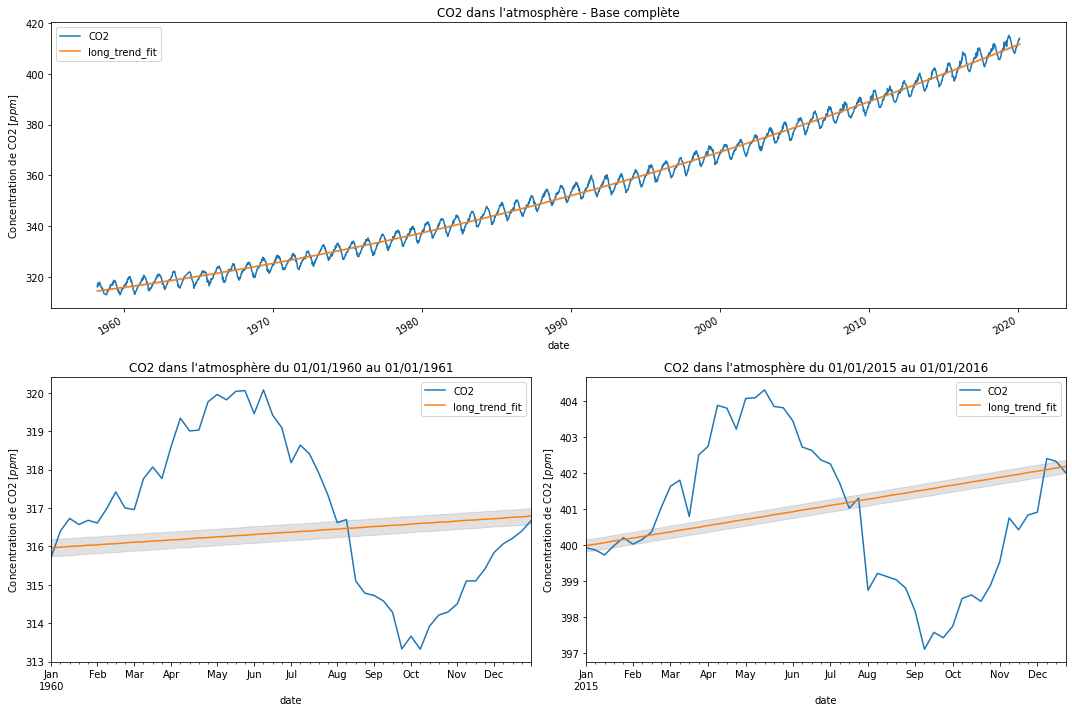

In [19]:
# Graphs de 2 périodes distinctes de 1 an
# Avec la courbe de tendance
fig = plt.figure()
 
# Définition des axes
ax1 = plt.subplot(223)
ax2 = plt.subplot(224)
ax3 = plt.subplot(211)

# Titres des graphs
ax1.set_title("CO2 dans l'atmosphère du 01/01/1960 au 01/01/1961")
ax2.set_title("CO2 dans l'atmosphère du 01/01/2015 au 01/01/2016")
ax3.set_title("CO2 dans l'atmosphère - Base complète")

# Labels des axes
ax1.set_ylabel("Concentration de CO2 [$ppm$]")
ax2.set_ylabel("Concentration de CO2 [$ppm$]")
ax3.set_ylabel("Concentration de CO2 [$ppm$]")

# Graph sur la base complète
data[mask1_1y][['CO2','long_trend_fit']].plot(ax=ax1, figsize=(15,10))
data[mask2_1y][['CO2','long_trend_fit']].plot(ax=ax2, figsize=(15,10))
data[['CO2','long_trend_fit']].plot(ax=ax3, figsize=(15,10))

ax1.fill_between(data[mask1_1y].index,
                 data['CI_lower_long_trend'][mask1_1y],
                 data['CI_upper_long_trend'][mask1_1y],
                 alpha= 0.25, color='#888888')
ax2.fill_between(data[mask2_1y].index, 
                 data['CI_lower_long_trend'][mask2_1y],
                 data['CI_upper_long_trend'][mask2_1y],
                 alpha= 0.25, color='#888888')
ax3.fill_between(data.index,
                 data['CI_lower_long_trend'],
                 data['CI_upper_long_trend'],
                 alpha= 0.25, color='#888888')

fig.tight_layout()

L'intervalle de confiance de la courbe ajustée sur la base entière est peu visible car très étroit.

## Caractérisation de l'oscillation périodique

Pour avoir un aperçu de l'oscillation saisonnière, commençons par retraiter les données pour soustraire l'effet de la tendance continue.

In [20]:
# Calculs des données en soustrayant la tendance continue
data['seasonal_oscillation'] = data['CO2'] - data['long_trend_fit'] + data['CO2'][0]

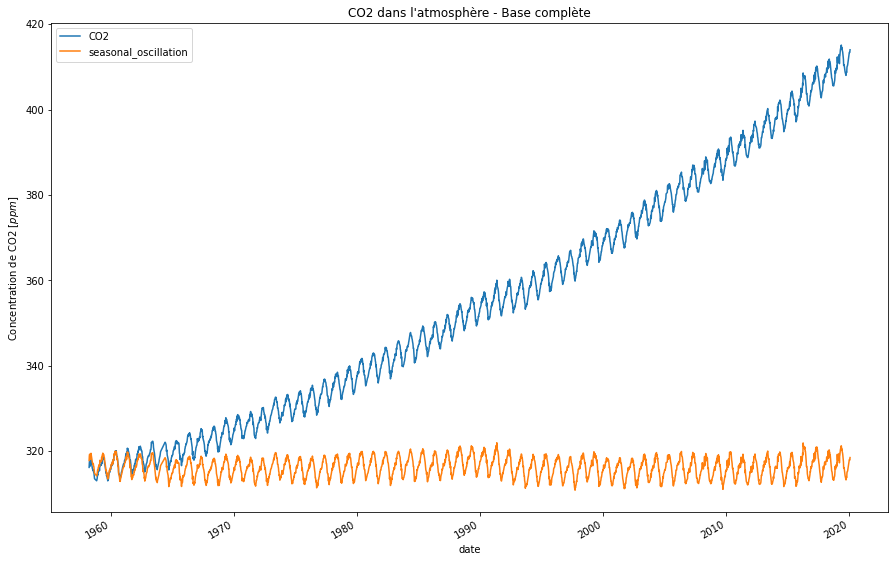

In [21]:
# Initialisation du graph
fig = plt.figure()

# Définition des axes
ax = plt.subplot(111)

# Titre du graph
ax.set_title("CO2 dans l'atmosphère - Base complète")

# Label des axes
ax.set_ylabel("Concentration de CO2 [$ppm$]")

# Graph sur la base complète
data[['CO2', 'seasonal_oscillation']].plot(ax=ax, figsize=(15,10));

La courbe orange représente les données de la variation de CO2 dans l'atmosphère sans l'effet de l'évolution continue que nous avons constaté au début de l'analyse.  
Nous constatons qu'en plus des oscillations saisonnières (période de 1 an), il semble avoir une oscillation, à faible amplitude, avec une période de l'ordre de 30 ans. Dans la suite de l'analyse, nous ne prendrons pas en compte cette variation.
En effet, avec une simple régression quadratique sur la tendance continue, le résultat est déjà très bon.  
Nous nous contenterons donc de caractériser les variations saisonnières avec une fonction sinus ajustée à toute la base de données. Cela aura pour effet d'avoir un modèle "ne fittant" pas parfaitement avec les données mais qui aura probablement plus de capacité à "généraliser" pour de bonnes prédictions futures. C'est le but premier de l'exercice.

In [22]:
# Définition de la fonction sinus
def sine(x, amp, freq, shift):
    return amp * np.sin(2*np.pi*x*freq) + shift

In [23]:
# Instanciation du modèle
model_seasonal_oscillation = Model(sine)
params_seasonal_oscillation = model_seasonal_oscillation.make_params(amp=7, freq=1, shift = 0)

# Calcul des meilleurs paramètres
result_seasonal_oscillation = model_seasonal_oscillation.fit(data['seasonal_oscillation'],
                                                             params_seasonal_oscillation, x=time)

In [24]:
#Affichage des meilleures paramètres calculés avec les intervalles de confiances
print(lmfit.fit_report(result_seasonal_oscillation.params))

[[Variables]]
    amp:    2.50225387 +/- 0.03484620 (1.39%) (init = 7)
    freq:   1.00450120 +/- 6.1470e-05 (0.01%) (init = 1)
    shift:  316.199477 +/- 0.02463756 (0.01%) (init = 0)


Avec ces résulats nous pouvons caractériser l'oscillation saisonnière comme suit :
- +/- 2.5 *ppm* sur une année.
- Une féquence de 1 année pour chaque oscillation. Ce qui conforme aux observations.
- Un décalage de 316.20 *ppm* qui correspond à la première mesure de la base de données.  

Les intervalles de confiance sont là aussi très restreints et n'apparaissent pas sur le graphique.

In [25]:
# Fonction de prédiction saisonnière
def seasonal_oscillation_fitted_curve(time, amp, freq, shift):
    seasonal_oscillation_CO2 = (amp*np.sin(2*np.pi*freq*time) + shift)
    return np.round(seasonal_oscillation_CO2, 2)

In [26]:
# Ajout d'une colonne dans le dataframe data
data['seasonal_oscillation_fit'] = np.around(result_seasonal_oscillation.best_fit, 2)

In [27]:
# Ajout des colonnes bandes inf et sup de l'intervalle de confiance sur l'oscillation saisonnière
# Avec 2 sigmas
data['CI_lower_seasonal_oscillation'] = np.around(result_seasonal_oscillation.best_fit -
                                        result_seasonal_oscillation.eval_uncertainty(sigma=2), 2)
data['CI_upper_seasonal_oscillation'] = np.around(result_seasonal_oscillation.best_fit +
                                        result_seasonal_oscillation.eval_uncertainty(sigma=2), 2)

In [28]:
# Définition de la période à afficher
# Echelle de temps 2010-2015
mask2013_2015 = (data.index > '2013-01-01') & (data.index < '2016-01-01')

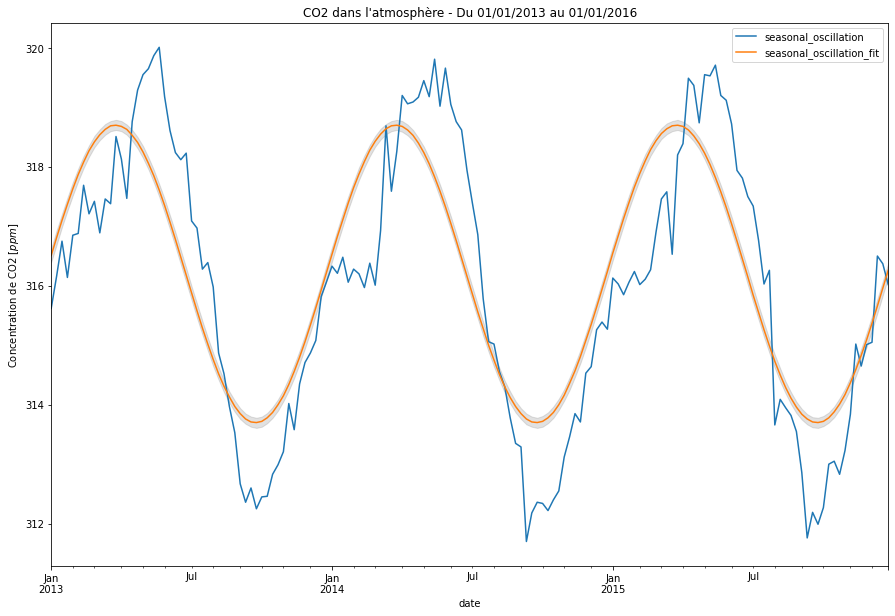

In [29]:
# Initialisation du graph
fig = plt.figure()

# Définition des axes
ax = plt.subplot(111)

# Titre du graph
ax.set_title("CO2 dans l'atmosphère - Du 01/01/2013 au 01/01/2016")

# Label des axes
ax.set_ylabel("Concentration de CO2 [$ppm$]")
data[mask2013_2015][['seasonal_oscillation', 'seasonal_oscillation_fit']].plot(ax=ax, figsize=(15,10))

ax.fill_between(data[mask2013_2015].index,
                data[mask2013_2015]['CI_lower_seasonal_oscillation'],
                data[mask2013_2015]['CI_upper_seasonal_oscillation'],
                 alpha= 0.25, color='#888888');

Comme annoncé précédemment, nous voyons que le modèle basé sur un simple sinus, ne colle pas parfaitement au données.  
Cela n'aura probablement pas un fort impact sur le résultat final.  
Nous voyons tout de même que l'intervalle de confiance est très resserré et à peine visible.

## Définition du modèle global

Dans la suite, nous créeons le modèle prenant en compte l'évolution continue et l'oscillation saisonnière.

In [30]:
# Ajout d'une colonne dans le dataframe data
data['global_fit'] = data['long_trend_fit'] + data['seasonal_oscillation_fit'] - data['CO2'][0]

In [31]:
# Ajout des colonnes bandes inf et sup de l'intervalle de confiance sur le modèle complet
# Avec 2 sigmas
data['CI_lower_global_fit'] = data['CI_lower_long_trend'] - data['CI_lower_seasonal_oscillation']
data['CI_upper_global_fit'] = data['CI_upper_long_trend'] + data['CI_upper_seasonal_oscillation']

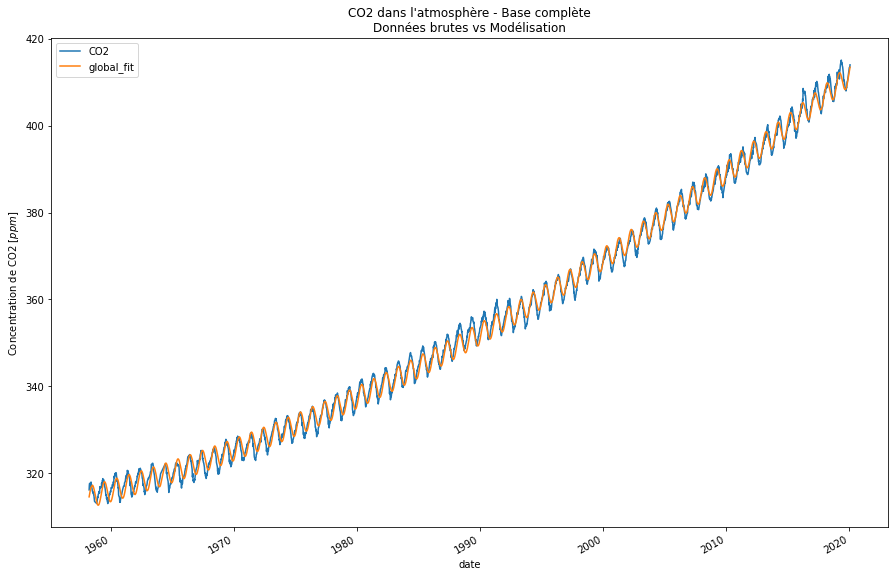

In [32]:
# Initialisation du graph
fig = plt.figure()

# Définition des axes
ax = plt.subplot(111)

# Titre du graph
ax.set_title("CO2 dans l'atmosphère - Base complète\nDonnées brutes vs Modélisation")

# Label des axes
ax.set_ylabel("Concentration de CO2 [$ppm$]")

# Graph sur la base complète
data[['CO2', 'global_fit']].plot(ax=ax, figsize=(15,10));

L'intervalle de confiance étant très fin, nous avons décidé de ne pas l'afficher.

In [33]:
# Estimation du coefficient de détermination
r2_score(data['CO2'], data['global_fit'])

0.997596481376051

L'intégration des oscillations prériodiques permet d'améliorer un peu plus le modèle initial.  
Au vu de la très bonne valeur de $r²$, nous resterons sur ce modèle pour faire les prédictions pour les années futures.

# Prédiction pour 2025

Dans les chapitres précedents, nous avons défini un modèle permettant d'intégrer les oscillations saisonnières à la tendance continue. Nous allons donc pouvoir tenter une prédiction de l'évolution du CO2 dans l'atmosphère pour toute l'année 2025.

In [34]:
# Définition des différentes dates de l'année 2025 à calculer
# Une date par semaine comme pour la base de sonnées initiale
pred_range = pd.date_range(start='2025/01/01', end='2025/12/31', freq='W')
pred_range.shape

(52,)

In [35]:
# Calcul du temps avec la même fonction que pour les calculs des chapitres précédents
time = dates_to_idx(pred_range)

In [36]:
# Calcul des prévisions pour l'année 2025
# Calcul sur la tendance longue et l'oscillation saisonnière
pred_long_trend_2025 = result_long_trend.eval(x=time)
pred_2025 = result_long_trend.eval(x=time) + result_seasonal_oscillation.eval(x=time) - data['CO2'][0]

In [37]:
# Calcul de la valeur moyenne avec le modèle complet
mean_2025 = round(np.mean(pred_2025))
mean_2025

425.0

In [38]:
# Calcul de la valeur moyenne avec le modèle sur la tendance générale
mean_long_trend_2025 = round(np.mean(pred_long_trend_2025))
mean_long_trend_2025

425.0

La valeur moyenne attendue de CO2 dans l'atmosphère pour 2025 est de 425 *ppm*.

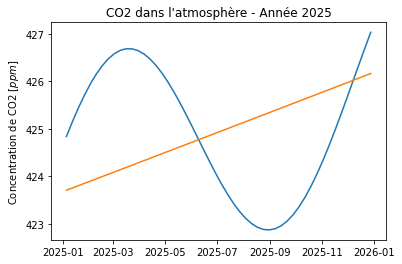

In [39]:
# Affichage des résulats
# Initialisation du graph
fig = plt.figure()

# Définition des axes
ax = plt.subplot(111)

# Titre du graph
ax.set_title("CO2 dans l'atmosphère - Année 2025")

# Label des axes
ax.set_ylabel("Concentration de CO2 [$ppm$]")
plt.plot(pred_range, pred_2025)
plt.plot(pred_range, pred_long_trend_2025);

L'oscillation saisonnière calculée respecte les caractérisques principales des relevés :
- Maximum dans la première moitié de l'année.
- Minimum dans la deuxième moitié de l'année.
- Valeur au 31/12/2025 supérieure à celle du 01/01/2025.

Nous voyons tout de même un déphasage (avance d'environ 1.5 mois) avec les données brutes. 
Comme nous l'avions pressenti au début de l'analyse, l'intégration des oscillations saisonnières dans le modèle ne permet pas d'améliorer les prédictions. Les 2 modèles (avec et sans intégration des oscillations saisonnières) donnent le même résulat (425 *ppm* de CO2 dans l'atmosphère).

In [40]:
# Préparation des échelles de temps pour le tracé des prédictions
hole_range = pd.date_range(start='2020/02/01', end='2024/12/31', freq='W')
time_hole = dates_to_idx(hole_range)

pred_hole_range = result_long_trend.eval(x=time_hole)
pred_hole = result_long_trend.eval(x=time_hole) + result_seasonal_oscillation.eval(x=time_hole) - data['CO2'][0]

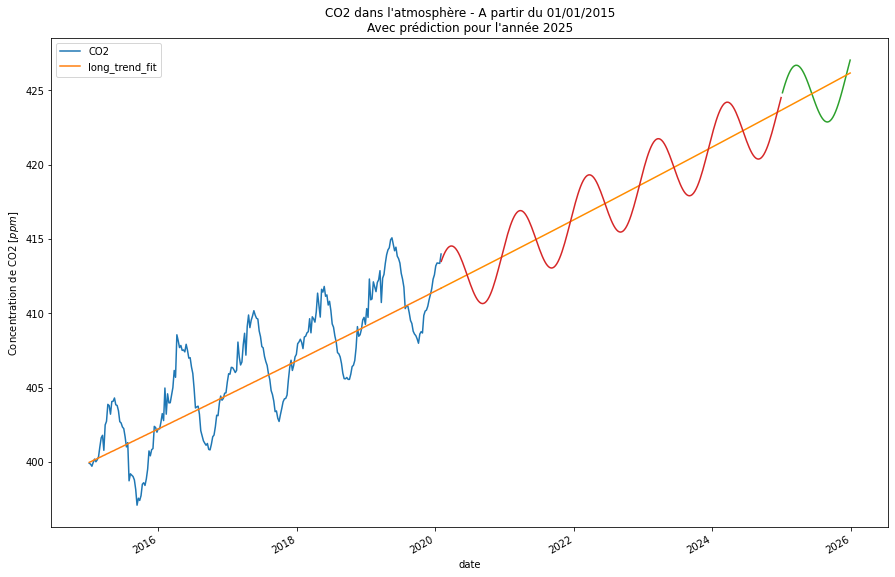

In [41]:
# Initialisation du graph
fig = plt.figure(figsize=(15,10))

# Définition des axes
ax = plt.subplot(111)

# Titre du graph
ax.set_title("CO2 dans l'atmosphère - A partir du 01/01/2015\nAvec prédiction pour l'année 2025")

# Label des axes
ax.set_ylabel("Concentration de CO2 [$ppm$]")

# Graph sur la base complète
data[data.index > '2015-01-01'][['CO2', 'long_trend_fit']].plot(ax=ax)
#pred_2025.plot()
plt.plot(hole_range, pred_hole_range, color='darkorange')

plt.plot(pred_range, pred_2025)
plt.plot(pred_range, pred_long_trend_2025, color='darkorange')
plt.plot(hole_range, pred_hole);

Ci-dessus la prédiction pour l'année 2025 complète (courbe verte) et sa tendance à long terme (courbe orange).  
Pour assurer une bonne lisibilité du graphique, les intervalles de confiance (très étroits) ne sont pas représentés.

# Conclusion

Nous avons vu qu'il est possible de définir un modèle de prédiction crédible et précis avec une simple régression quadratique.  L'ajout des oscillations saisonnières permet tout de même d'améliorer très légèrement la qualité des prédictions.  
D'un point de vue purement analytique, il serait intéressant de faire une transformée de Fourier sur les données brutes pour caractériser la variation périodique de 30 ans.